In [9]:
# 1. Import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#import warnings
#warnings.filterwarnings("ignore")


In [10]:
# 2. Load dataset
df = pd.read_csv("customer_data.csv", parse_dates=["last_purchase_date"])
df.head()


,customer_id,last_purchase_date,total_orders,total_spent,region,channel,preferred_discount,loyalty_score,recency_days,is_dormant
0,CUST0000,2025-06-12,4,318.04,North,Mobile,0.145660,0.037720,46,0
1,CUST0001,2024-09-30,6,181.54,East,InStore,0.311224,0.544539,301,1
2,CUST0002,2025-03-19,3,314.99,South,Web,0.166893,0.537934,131,1
3,CUST0003,2025-04-28,1,871.96,North,Mobile,0.349710,0.571506,91,0
4,CUST0004,2025-07-12,2,180.30,South,Web,0.176844,0.637859,16,0


In [11]:
# 3. Feature engineering
today = datetime(2025, 7, 28)

df['recency_days'] = (today - df['last_purchase_date']).dt.days
df['frequency'] = df['total_orders']
df['monetary'] = df['total_spent']

# Define features and target
features = ['recency_days', 'frequency', 'monetary']
X = df[features]
y = df['is_dormant']


In [12]:
# 4. Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [13]:
# 5. Instantiate and train LGBMClassifier with callbacks
clf = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    learning_rate=0.05,
    n_estimators=1000,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=True),
        log_evaluation(period=50)
    ]
)


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.81013
Early stopping, best iteration is:
[46]	valid_0's auc: 0.810353


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


              precision    recall  f1-score   support

           0       0.69      0.71      0.70       887
           1       0.76      0.74      0.75      1113

    accuracy                           0.73      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.73      0.73      0.73      2000

Confusion Matrix:
 [[626 261]
 [286 827]]
ROC AUC Score: 0.8103528961306927


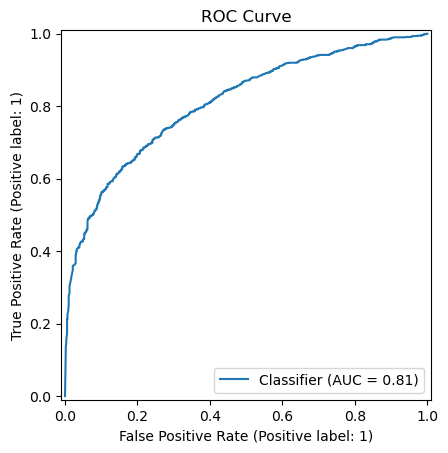

In [14]:
# 6. Evaluation
y_pred_proba = clf.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))

RocCurveDisplay.from_predictions(y_val, y_pred_proba)
plt.title("ROC Curve")
plt.show()


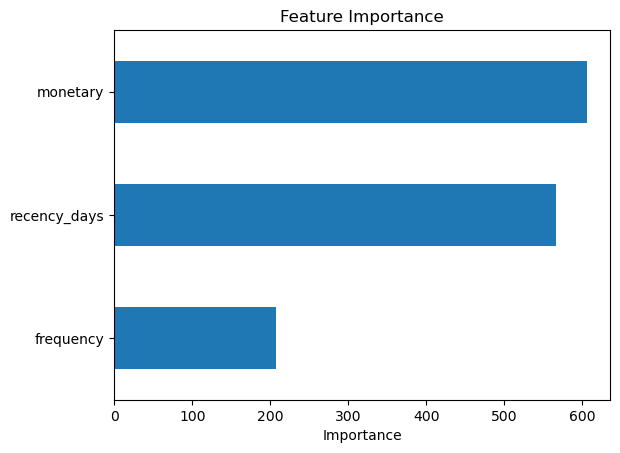

In [15]:
# 7. Feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title="Feature Importance")
plt.xlabel("Importance")
plt.show()


In [16]:
# 8. Save model
clf.booster_.save_model("lgbm_dormancy_model.txt")
joblib.dump(X.columns.tolist(), "feature_names.pkl")

['feature_names.pkl']